In [1]:
!pip install kaggle -q

In [2]:
import os
import json

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Data Collection:

In [4]:
kaggle_config = json.load(open("kaggle.json"))  # login to kaggle > verify account > profile icon > settings > create new API token

In [5]:
kaggle_config.keys()

dict_keys(['username', 'key'])

In [6]:
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

In [7]:
# loading the dataset using kaggle api
!kaggle datasets download notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0


In [8]:
!ls

kaggle.json  sample_data  spotify-million-song-dataset.zip


In [9]:
with zipfile.ZipFile('spotify-million-song-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [10]:
# loading the dataset to a pandas dataframe
df = pd.read_csv("/content/spotify_millsongdata.csv")

In [11]:
df.shape

(57650, 4)

In [12]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [14]:
df.isnull().sum()

,0
artist,0
song,0
link,0
text,0


In [15]:
# Top artists and songs
top_artists = df['artist'].value_counts().head(10)
print("\nTop 10 Artists:")
print(top_artists)


Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [16]:
df = df.sample(10000)

df = df.drop('link', axis=1).reset_index(drop=True)


In [17]:
df.shape

(10000, 3)

In [18]:
df.head()

,artist,song,text
0,Dusty Springfield,Daydreaming,(You gotta wake up) \r\nYou don't commit to m...
1,Yelawolf,Radio,[Chorus] \r\nI can't seem to get you off my m...
2,Coldplay,Travis - Why Does It Always Rain On Me?,"I can't sleep tonight \r\nEverybody saying, ""..."
3,Cliff Richard,High Class Baby,"Well you can't be my lovin' baby, you ain't go..."
4,Hillsong United,God Of All Creation,Verse 1 \r\nI'm totally abandoned to You \r\...


In [19]:
# WordCloud for song lyrics
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

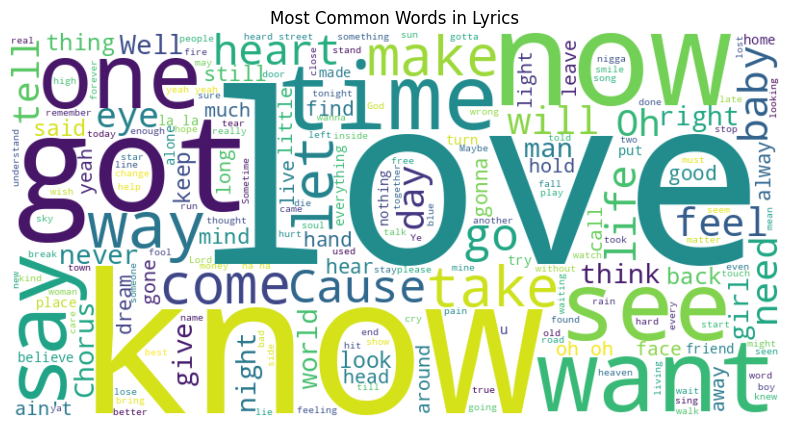

In [20]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Lyrics")
plt.show()

Data Preprocessing


In [21]:
# download nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
stop_words = set(stopwords.words('english'))

In [23]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [24]:
# Apply preprocessing to lyrics
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [25]:
df.head()

,artist,song,text,cleaned_text
0,Dusty Springfield,Daydreaming,(You gotta wake up) \r\nYou don't commit to m...,got ta wake dont commit wont make start dont t...
1,Yelawolf,Radio,[Chorus] \r\nI can't seem to get you off my m...,chorus cant seem get mind turn station im stil...
2,Coldplay,Travis - Why Does It Always Rain On Me?,"I can't sleep tonight \r\nEverybody saying, ""...",cant sleep tonight everybody saying everything...
3,Cliff Richard,High Class Baby,"Well you can't be my lovin' baby, you ain't go...",well cant lovin baby aint got style im gon na ...
4,Hillsong United,God Of All Creation,Verse 1 \r\nI'm totally abandoned to You \r\...,verse im totally abandoned im lost inside rive...


In [26]:
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [27]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [28]:
# Recommendation Function
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    # Find the index of the song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset!"   # can be reworked to compare for songs not present in the dataset
    idx = idx[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Get song indices
    song_indices = [i[0] for i in sim_scores]

    # Return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]

In [29]:
df["song"][3]

'High Class Baby'

In [31]:
# Example Recommendation
print("\nRecommendations for the song 'Blinded By Rainbows':")
recommendations = recommend_songs("For The First Time") # df["song"][2]
print(recommendations)


Recommendations for the song 'Blinded By Rainbows':
              artist                 song
4064  Wilson Pickett  I Found A True Love
3168   Kenny Chesney      Makes Me Wonder
867        Bob Seger             I Wonder
5188    Bill Withers       Friend Of Mine
6844     Dean Martin  Because You're Mine
